In [1]:
import torch
import glob as gb
import numpy as np
from PIL import Image
import os

import random
import torch.nn as nn
import pandas as pd 

from numpy import dot
from numpy.linalg import norm
import matplotlib.pyplot as plt
import random

from facenet_pytorch import MTCNN, InceptionResnetV1
import torchvision.transforms as transforms
import torch.backends.cudnn as cudnn

os.sys.path.append('../')
os.sys.path.append('../models/')
from utils.loss import cos_sim

random.seed(1)
np.random.seed(1)

In [2]:
# SR Model Initialization

GPU_IN_USE = torch.cuda.is_available()

if GPU_IN_USE:
    cudnn.benchmark = True
    
device = torch.device('cuda' if GPU_IN_USE else 'cpu')

In [3]:
# Testing upsampling via SR
class SuperResolveDL:
    def __init__(self, model, size, channel, resize=True):
        self.model = model
        self.size = size
        self.channel = channel
        self.resize = resize
        
    def __call__(self, path=''):
        if self.channel == 1:
            img = Image.open(path).convert('YCbCr').resize((self.size,self.size),resample=Image.BICUBIC)
            upsample, cb, cr = img.split()
            if not self.resize:
                upsample, _, _ = Image.open(path).convert('YCbCr').resize((40,40),resample=Image.BICUBIC).split()
        elif self.channel == 3:
            if self.resize: 
                upsample = Image.open(path).convert('RGB').resize((self.size,self.size),resample=Image.BICUBIC)
            else:
                upsample = Image.open(path).convert('RGB')
        else:
            raise Exception('Channel option not listed')
        
        data = (transforms.ToTensor()(upsample)).view(1, self.channel, upsample.size[1], upsample.size[0])
        data = data.to(device)
        out = self.model(data)
        out = out.cpu()
        out_img = out.data[0].numpy()
        out_img *= 255.0
        out_img = out_img.clip(0, 255)
                
        if self.channel == 1:
            out_img = Image.fromarray(np.uint8(out_img[0]), mode='L')
            out_img = Image.merge('YCbCr', [out_img, cb, cr]).convert('RGB')
            #out_img = out_img.resize((160,160), Image.BICUBIC)
        if self.channel == 3:
            out_img = out_img.transpose((1,2,0))
            out_img = Image.fromarray(np.uint8(out_img), mode='RGB')
            out_img = out_img.resize((160,160), Image.BICUBIC)

        return out_img
    
    
# Testing upsampling via Bicubic

def load_image(path='', size=160, resize=True): # Bicubic
    img = Image.open(path)
    if resize:
        img = img.resize((size,size), resample=Image.BICUBIC)
    return img

In [4]:
def return_embedding(img_path):
    img_as_tensor = transforms.ToTensor()(load_image(img_path))
    img_emb = resnet(img_as_tensor.unsqueeze(0)).squeeze(0).detach().numpy()
    return img_emb

def return_batch_embedding(imgs_path):
    img_array = [transforms.ToTensor()(load_image(path)) for path in imgs_path]
    emb_array = [resnet(img.unsqueeze(0)).squeeze(0).detach().numpy() for img in img_array]
    return np.array(emb_array)

In [27]:
#model_path = '../checkpoints/SRCNN_x4_epoch_50.pth'
#model_path = '../checkpoints/SRGAN_x4_epoch_30.pth'
#model_path = '../checkpoints/SRGAN_FaceLoss_x4_epoch_28.pth'
model_path = '../checkpoints/SRGAN_coord_FaceLoss_x4_epoch_24.pth'
#model_path = '../checkpoints/SubCNN_coord_x4_epoch_50.pth'
#model_path = '../checkpoints/SubCNN_x4_epoch_50.pth'
#model_path = '../checkpoints/FSRCNN_coord_x4_epoch_50.pth'

model = torch.load(model_path, map_location=lambda storage, loc: storage.cuda(0))
model = model.to(device)

/opt/anaconda3/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'GAN_model.Generator' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [28]:
resnet = InceptionResnetV1(pretrained='vggface2').eval()

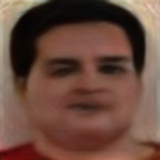

In [29]:
load_image = SuperResolveDL(model, size=56, channel=3, resize=True)
load_image('/home/jupyter/ICB-RW/Margin1.3_40/gallery/003_f.jpg')

In [30]:
def l2_error(a,b):
    return sum((a-b)**2) 

low_res_img_path = '/media/angelo/DATEN/Datasets/CelebA/LR_112/test/018540.jpg'
original_img_path = '/media/angelo/DATEN/Datasets/CelebA/HR/test/018540.jpg'
test_img_path = '/media/angelo/DATEN/Datasets/CelebA/HR/test/018590.jpg'

#low_res = '/media/angelo/DATEN/Datasets/Dados_TCC_Joao/Material TCC/Classe3/Classe/faces_bd/'

lr_emb = return_embedding(low_res_img_path)
hr_emb = return_embedding(original_img_path)
test_emb = return_embedding(test_img_path)

print('Identity Loss Fake Img and Real Img')
print(cos_sim(lr_emb, hr_emb))

print('Euclidean Distance Fake Img and Real Img')
print(np.linalg.norm(lr_emb-hr_emb))

print('Identity Loss Fake Img and Random Img')
print(cos_sim(lr_emb, test_emb))

print('Euclidean Distance Fake Img and Random Img')
print(np.linalg.norm(lr_emb-test_emb))

print('Identity Loss Real Img and Random Img')
print(cos_sim(hr_emb, test_emb))

print('Euclidean Distance Real Img and Random Img')
print(np.linalg.norm(hr_emb-test_emb))

FileNotFoundError: [Errno 2] No such file or directory: '/media/angelo/DATEN/Datasets/CelebA/LR_112/test/018540.jpg'

In [31]:
img_path = '/home/jupyter/ICB-RW/Margin1.3_40/'

gallery_path = gb.glob(img_path + 'gallery/*.jpg')
gallery_names = [str(int(os.path.splitext(name)[0][:-2])) for name in os.listdir(img_path + 'gallery/')]

face_embeddings = return_batch_embedding(gallery_path)

In [32]:
# Checking consistency

probe_path = img_path + 'probe/'
student_pool_list = gallery_names

real_embedding = return_embedding(img_path + 'gallery/00' + student_pool_list[0] + '_f.jpg')

guilty_student_path = gb.glob(probe_path + student_pool_list[0] + '/*.jpg')
sample_1_student = gb.glob(probe_path + student_pool_list[1] + '/*.jpg')
sample_2_student = gb.glob(probe_path + student_pool_list[2] + '/*.jpg')
sample_3_student = gb.glob(probe_path + student_pool_list[3] + '/*.jpg')

print('For student ' + student_pool_list[0])
print('Similarity with his own probe photos: ')

guilty_student_emb = return_batch_embedding(guilty_student_path)
similarities = [cos_sim(real_embedding, guilty_student_emb[i]) for i in range(5)]
print(similarities)

print('Similarity with probe photos of ' + student_pool_list[1])

guilty_student_emb = return_batch_embedding(sample_1_student)
similarities = [cos_sim(real_embedding, guilty_student_emb[i]) for i in range(5)]
print(similarities)

print('Similarity with probe photos of ' + student_pool_list[2])

guilty_student_emb = return_batch_embedding(sample_2_student)
similarities = [cos_sim(real_embedding, guilty_student_emb[i]) for i in range(5)]
print(similarities)

print('Similarity with probe photos of ' + student_pool_list[3])

guilty_student_emb = return_batch_embedding(sample_3_student)
similarities = [cos_sim(real_embedding, guilty_student_emb[i]) for i in range(5)]
print(similarities)

For student 90
Similarity with his own probe photos: 
[0.4736747145652771, 0.6583143174648285, 0.43756556510925293, 0.8529369384050369, 0.7463511824607849]
Similarity with probe photos of 55
[0.6880030632019043, 0.5667327642440796, 0.686432808637619, 0.8948652818799019, 0.6015729010105133]
Similarity with probe photos of 10
[1.1121953055262566, 1.059351522475481, 1.0084868567064404, 1.2658537030220032, 1.2718202471733093]
Similarity with probe photos of 91
[0.6924810111522675, 0.6158686280250549, 0.6175069808959961, 0.3257843852043152, 0.5846003890037537]


In [33]:
# Experimentation

origin_path = '/home/jupyter/ICB-RW/'

possible_paths = ['Margin1.3_40/', 'NoMargin_40/', 'NoMargin_NoSize/']

random.seed(1)
np.random.seed(1)

for data_size in possible_paths:
    
    print('For ' + data_size)

    img_path = origin_path + data_size
    
    gallery_path = gb.glob(img_path + 'gallery/*.jpg')
    gallery_names = [str(int(os.path.splitext(name)[0][:-2])) for name in os.listdir(img_path + 'gallery/')]

    face_embeddings = return_batch_embedding(gallery_path)

    probe_path = img_path + 'probe/'
    student_pool_list = gallery_names
    average_accuracy = 0

    for _ in range(5): # Execute 5 times to check consistency of results
        accuracy = 0
        error = []
        for index, student in enumerate(student_pool_list):
            probe_list_students = student_pool_list.copy()
            watch_list_emb = []
            watch_list_images = []

            # First embeddings is always for the guilty student  
            guilty_student_image = probe_path + student + '/' + random.choice(os.listdir(probe_path + student))
            watch_list_emb.append(return_embedding(guilty_student_image))

            probe_list_students.remove(student)

            watch_list_students = random.sample(probe_list_students, 4)

            for suspect in watch_list_students:
                image = random.choice(os.listdir(probe_path + suspect))
                watch_list_images.append(probe_path + suspect + '/' + image)

            for suspect in watch_list_images:
                watch_list_emb.append(return_embedding(suspect))

            similarities = [cos_sim(face_embeddings[index], watch_list_emb[i]) for i in range(5)]

            # If the least distance is the first element, let's sum 1
            if np.argmin(np.array(similarities)) == 0:
                accuracy += 1
            else:
                error.append(student)
        
        average_accuracy += accuracy/len(student_pool_list)
        
        print("Accuracy: {0:.2f}".format(accuracy/len(student_pool_list)))
        #print('Error happend with the following students: ')
        #print(error)
    print('Average accuracy was {:.2f}'.format(100*average_accuracy/5))
    print('_____________________________________________________________')

For Margin1.3_40/
Accuracy: 0.70
Accuracy: 0.71
Accuracy: 0.76
Accuracy: 0.77
Accuracy: 0.72
Average accuracy was 73.11
_____________________________________________________________
For NoMargin_40/
Accuracy: 0.79
Accuracy: 0.79
Accuracy: 0.77
Accuracy: 0.81
Accuracy: 0.73
Average accuracy was 77.78
_____________________________________________________________
For NoMargin_NoSize/
Accuracy: 0.80
Accuracy: 0.88
Accuracy: 0.83
Accuracy: 0.86
Accuracy: 0.82
Average accuracy was 83.78
_____________________________________________________________
